# Лабораторна робота 4: Advanced Nets

**Викладач:** Наталія Сахненко

**Студент:** Зубко Дмитро Едуардович

## Опис завдання
1.  Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір). 
Вирішіть завдання щодо генерації текстів або машинного перекладу. Особливо вітаються україномовні моделі.  

2. Проведіть експерименти з моделями бібліотеки Hugging Face (раніше - Hugging Face Transformers, https://huggingface.co/) за допомогою (наприклад) Pipeline модуля

3. Завдання щодо генерації або стилізації зображень (на вибір)
Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE/Diffusion).

# Завдання 1. Машинний переклад за допомогою NMT з Transformers

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings
import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization
import matplotlib.pyplot as plt


# Шлях до вашого локального файлу ukr.txt
text_file = pathlib.Path("ukr.txt")

text_pairs = []
with open(text_file, encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split("\t")
        if len(parts) >= 2:
            eng, ukr = parts[0], parts[1]
            ukr = "[start] " + ukr + " [end]"
            text_pairs.append((eng, ukr))

random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
ukr_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_ukr_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
ukr_vectorization.adapt(train_ukr_texts)


def format_dataset(eng, ukr):
    eng = eng_vectorization(eng)
    ukr = ukr_vectorization(ukr)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": ukr[:, :-1],
        },
        ukr[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, ukr_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    ukr_texts = list(ukr_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, ukr_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
test_ds = make_dataset(test_pairs)

for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

159432 total pairs
111604 training pairs
23914 validation pairs
23914 test pairs
inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


In [2]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        inputs, encoder_outputs = inputs
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is None:
            inputs_padding_mask, encoder_outputs_padding_mask = None, None
        else:
            inputs_padding_mask, encoder_outputs_padding_mask = mask

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
            query_mask=inputs_padding_mask,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            query_mask=inputs_padding_mask,
            key_mask=encoder_outputs_padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


embed_dim = 128
latent_dim = 512
num_heads = 4

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

transformer = keras.Model(
    {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    decoder_outputs,
    name="transformer",
)

epochs = 20

transformer.summary()

# Використання AdamW
optimizer = keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

transformer.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(ignore_class=0),
    metrics=["accuracy"],
)

# Learning Rate Scheduler
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=0.00001
)
# Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
# Saving the best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "best_transformer.keras", monitor="val_loss", save_best_only=True
)

history = transformer.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint],
)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs (InputLayer)   │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_inputs (InputLayer)   │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ positional_embedding          │ (None, None, 128)         │       1,922,560 │ encoder_inputs[0][0]       │
│ (PositionalEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, None)              │               0 │ encoder_inputs[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ positional_embedding_1        │ (None, None, 128)         │       1,922,560 │ decoder_inputs[0][0]       │
│ (PositionalEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder           │ (None, None, 128)         │         396,032 │ positional_embedding[0][0… │
│ (TransformerEncoder)          │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_1 (NotEqual)        │ (None, None)              │               0 │ decoder_inputs[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_decoder           │ (None, None, 128)         │         660,096 │ positional_embedding_1[0]… │
│ (TransformerDecoder)          │                           │                 │ transformer_encoder[0][0], │
│                               │                           │                 │ not_equal_1[0][0],         │
│                               │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, None, 128)         │               0 │ transformer_decoder[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, None, 15000)       │       1,935,000 │ dropout_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 6,836,248 (26.08 MB)

 Trainable params: 6,836,248 (26.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


C:\Users\zubko\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\zubko\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\zubko\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. D

1744/1744 ━━━━━━━━━━━━━━━━━━━━ 235s 133ms/step - accuracy: 0.1037 - loss: 4.8802 - val_accuracy: 0.1689 - val_loss: 2.5059 - learning_rate: 0.0010
Epoch 2/20
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 230s 132ms/step - accuracy: 0.1681 - loss: 2.5595 - val_accuracy: 0.1879 - val_loss: 1.8589 - learning_rate: 0.0010
Epoch 3/20
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 230s 132ms/step - accuracy: 0.1863 - loss: 1.9086 - val_accuracy: 0.1960 - val_loss: 1.5891 - learning_rate: 0.0010
Epoch 4/20
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 231s 133ms/step - accuracy: 0.1974 - loss: 1.5717 - val_accuracy: 0.2014 - val_loss: 1.4773 - learning_rate: 0.0010
Epoch 5/20
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 231s 132ms/step - accuracy: 0.2047 - loss: 1.3638 - val_accuracy: 0.2031 - val_loss: 1.4205 - learning_rate: 0.0010
Epoch 6/20
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 231s 132ms/step - accuracy: 0.2096 - loss: 1.2273 - val_accuracy: 0.2051 - val_loss: 1.3791 - learning_rate: 0.0010
Epoch 7/20
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 230s 132ms/step - acc

## Оцінка моделі

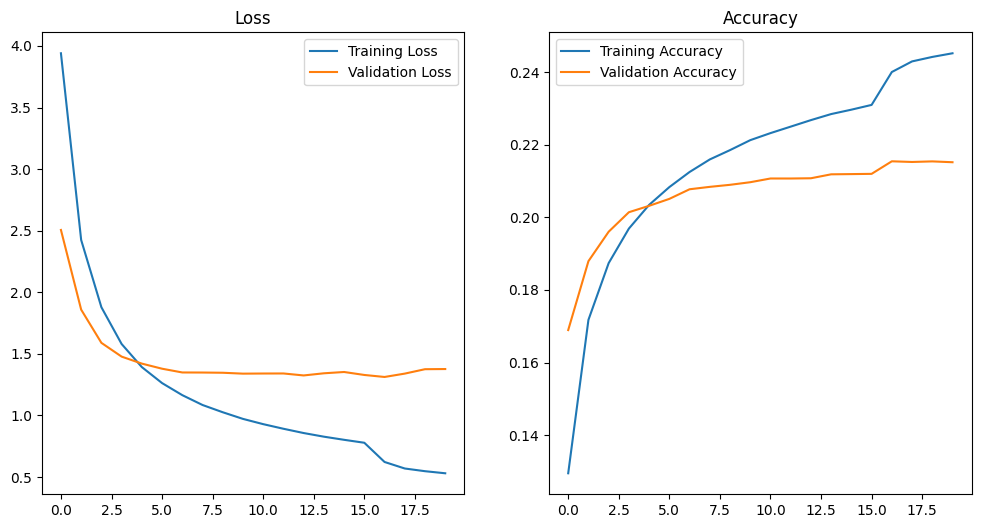

In [3]:
# Plotting training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.show()

In [4]:
# Оцінка моделі на тестових даних
test_loss, test_accuracy = transformer.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


ukr_vocab = ukr_vectorization.get_vocabulary()
ukr_index_lookup = dict(zip(range(len(ukr_vocab)), ukr_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ukr_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer(
            {
                "encoder_inputs": tokenized_input_sentence,
                "decoder_inputs": tokenized_target_sentence,
            }
        )
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = ukr_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

# Example of using the model
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(10):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(f"Input: {input_sentence}")
    print(f"Translation: {translated}")
    print("-" * 50)

374/374 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.2148 - loss: 1.3012
Test Loss: 1.3120518922805786
Test Accuracy: 0.215760737657547
Input: I'm happy that we came to Australia.
Translation: [start] Я радий що ми приїхали до Австралії [end]
--------------------------------------------------
Input: I'm free today.
Translation: [start] Я сьогодні вільний [end]
--------------------------------------------------
Input: I want a massage. I need to relax.
Translation: [start] Я хочу масаж якби мені потрібно розслабитися [end]
--------------------------------------------------
Input: My sister is very intelligent.
Translation: [start] Моя сестра дуже розумна [end]
--------------------------------------------------
Input: Tom is our interpreter.
Translation: [start] Том — наш перекладач [end]
--------------------------------------------------
Input: Is everybody okay?
Translation: [start] У всіх все гаразд [end]
--------------------------------------------------
Input: Do you think I'm u

In [5]:
input_sentence = "i see that you are very crazy, but i think"
translated = decode_sequence(input_sentence)
print(f"Input: {input_sentence}")
print(f"Translation: {translated}")
print("-" * 50)

Input: i see that you are very crazy, but i think
Translation: [start] Я бачу що ти дуже божевільний але я думаю [end]
--------------------------------------------------


# Завдання 2. Експерименти з моделями бібліотеки Hugging Face

## Підбиття підсумків

In [6]:
from transformers import AutoTokenizer, T5ForConditionalGeneration, pipeline

tokenizer = AutoTokenizer.from_pretrained('ukr-models/uk-summarizer')
model = T5ForConditionalGeneration.from_pretrained('ukr-models/uk-summarizer')

ppln = pipeline("summarization", model=model, tokenizer=tokenizer, device=0, max_length=128, num_beams=4, no_repeat_ngram_size=2, clean_up_tokenization_spaces=True)

text = "На знімках військових баз від Maxar Technologies і Planet Labs видно, що на авіабазу Хмеймім прибули вантажні літаки Ан-124 (найбільші у світі вантажні літаки, які здатні перевозити до 150 тонн вантажу), три транспортні літаки Іл-76, а також вантажні літаки більш дрібних моделей - три Ан-32 і один Ан-72. У літаків відкриті носові відсіки для прийому важкого обладнання."
ppln(text)

C:\Users\zubko\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
C:\Users\zubko\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zubko\.cache\huggingface\hub\models--ukr-models--uk-summarizer. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by settin

[{'summary_text': 'На авіабазу Хмеймім на півночі США прибули вантажні літаки Ан-124, які здатні перевозити до 150 тонн важкого обладнання.'}]

## Класифікація

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def predict_sentiment(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_map = {0: "Very Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Very Positive"}
    return [sentiment_map[p] for p in torch.argmax(probabilities, dim=-1).tolist()]

texts = [
    "Мені дуже сподобалася ця вистава!", "Обслуговування було жахливим.", "Книга була посередньою。",
    "Ця гра така собі", "Ця гра на один раз", "Ця гра нормальна"
]

for text, sentiment in zip(texts, predict_sentiment(texts)):
    print(f"Text: {text}\nSentiment: {sentiment}\n")

Text: Мені дуже сподобалася ця вистава!
Sentiment: Very Positive

Text: Обслуговування було жахливим.
Sentiment: Very Negative

Text: Книга була посередньою。
Sentiment: Negative

Text: Ця гра така собі
Sentiment: Very Negative

Text: Ця гра на один раз
Sentiment: Very Negative

Text: Ця гра нормальна
Sentiment: Neutral



# 3. Перенесення стилю

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg19
from IPython.display import Image, display
import matplotlib.pyplot as plt  # Додано для виводу графіків
from tqdm import tqdm # Для прогрес-бара

# Задайте шляхи до ваших зображень тут
base_image_path = "clear.jpg" # Замініть на свій шлях
style_reference_image_path = "my_pocher1.jpg" # Замініть на свій шлях
result_prefix = "generated_image"

# Ваги різних компонентів втрат
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Розміри згенерованого зображення
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# Відображення вхідних зображень (закоментовано, якщо не потрібно)
# display(Image(base_image_path))
# display(Image(style_reference_image_path))

def preprocess_image(image_path):
    # Функція для відкриття, зміни розміру та форматування зображень у тензори
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(x):
    # Функція для перетворення тензора в зображення
    x = x.reshape((img_nrows, img_ncols, 3))
    # Відновлення центрування
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # Перетворення 'BGR' -> 'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# Матриця Грама для тензора
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

# Функція втрат для стилю
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

# Функція втрат для контенту
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

# Функція total variation loss
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

# VGG19 з попередньо навченими вагами
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Отримання виходів для кожного шару
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Модель для отримання активацій
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

# Шари для втрат
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    loss = tf.zeros(shape=())

    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )

    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

# Оптимізатор
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

# Підготовка вхідних даних
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 3000
losses_history = []

progress_bar = tqdm(range(1, iterations + 1), desc="Stylizing Image")

for i in progress_bar:
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])

    losses_history.append(loss.numpy())

    progress_bar.set_postfix({'loss': loss.numpy()})

    if i % 100 == 0:
         print(f"Iteration {i}/{iterations}, Total Loss: {loss.numpy()}")

Stylizing Image:   0%|                                                                        | 0/3000 [00:00<?, ?it/s]C:\Users\zubko\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_18']. Received: the structure of inputs=*
  warnings.warn(
Stylizing Image:   3%|█▌                                              | 100/3000 [00:32<15:42,  3.08it/s, loss=1.44e+3]

Iteration 100/3000, Total Loss: 1436.7239990234375


Stylizing Image:   7%|███▎                                             | 200/3000 [01:05<15:04,  3.09it/s, loss=1.2e+3]

Iteration 200/3000, Total Loss: 1203.42138671875


Stylizing Image:  10%|████▉                                            | 300/3000 [01:37<14:32,  3.09it/s, loss=1.1e+3]

Iteration 300/3000, Total Loss: 1101.582763671875


Stylizing Image:  13%|██████▍                                         | 400/3000 [02:10<14:17,  3.03it/s, loss=1.04e+3]

Iteration 400/3000, Total Loss: 1043.8502197265625


Stylizing Image:  17%|████████                                        | 500/3000 [02:42<13:29,  3.09it/s, loss=1.01e+3]

Iteration 500/3000, Total Loss: 1006.2662963867188


Stylizing Image:  20%|██████████▍                                         | 600/3000 [03:14<12:54,  3.10it/s, loss=979]

Iteration 600/3000, Total Loss: 979.4443359375


Stylizing Image:  23%|████████████▏                                       | 700/3000 [03:47<12:24,  3.09it/s, loss=960]

Iteration 700/3000, Total Loss: 959.6760864257812


Stylizing Image:  27%|█████████████▊                                      | 800/3000 [04:19<11:44,  3.12it/s, loss=944]

Iteration 800/3000, Total Loss: 944.3780517578125


Stylizing Image:  30%|███████████████▌                                    | 900/3000 [04:51<11:23,  3.07it/s, loss=932]

Iteration 900/3000, Total Loss: 931.9180297851562


Stylizing Image:  33%|█████████████████                                  | 1000/3000 [05:24<10:46,  3.10it/s, loss=922]

Iteration 1000/3000, Total Loss: 921.634033203125


Stylizing Image:  37%|██████████████████▋                                | 1100/3000 [05:56<10:10,  3.11it/s, loss=913]

Iteration 1100/3000, Total Loss: 912.90185546875


Stylizing Image:  40%|████████████████████▍                              | 1200/3000 [06:28<09:40,  3.10it/s, loss=905]

Iteration 1200/3000, Total Loss: 905.3679809570312


Stylizing Image:  43%|██████████████████████                             | 1300/3000 [07:00<09:04,  3.12it/s, loss=899]

Iteration 1300/3000, Total Loss: 898.8515625


Stylizing Image:  47%|███████████████████████▊                           | 1400/3000 [07:33<08:36,  3.10it/s, loss=893]

Iteration 1400/3000, Total Loss: 893.1803588867188


Stylizing Image:  50%|█████████████████████████▌                         | 1500/3000 [08:05<08:03,  3.10it/s, loss=888]

Iteration 1500/3000, Total Loss: 888.15185546875


Stylizing Image:  53%|███████████████████████████▏                       | 1600/3000 [08:37<07:34,  3.08it/s, loss=884]

Iteration 1600/3000, Total Loss: 883.665283203125


Stylizing Image:  57%|████████████████████████████▉                      | 1700/3000 [09:10<06:58,  3.11it/s, loss=880]

Iteration 1700/3000, Total Loss: 879.642822265625


Stylizing Image:  60%|██████████████████████████████▌                    | 1800/3000 [09:42<06:27,  3.10it/s, loss=876]

Iteration 1800/3000, Total Loss: 875.9754638671875


Stylizing Image:  63%|████████████████████████████████▎                  | 1900/3000 [10:14<05:54,  3.10it/s, loss=873]

Iteration 1900/3000, Total Loss: 872.6898193359375


Stylizing Image:  67%|██████████████████████████████████                 | 2000/3000 [10:47<05:21,  3.11it/s, loss=870]

Iteration 2000/3000, Total Loss: 869.71484375


Stylizing Image:  70%|███████████████████████████████████▋               | 2100/3000 [11:19<04:53,  3.06it/s, loss=867]

Iteration 2100/3000, Total Loss: 867.0034790039062


Stylizing Image:  73%|█████████████████████████████████████▍             | 2200/3000 [11:51<04:18,  3.09it/s, loss=865]

Iteration 2200/3000, Total Loss: 864.5225219726562


Stylizing Image:  77%|███████████████████████████████████████            | 2300/3000 [12:24<03:46,  3.09it/s, loss=862]

Iteration 2300/3000, Total Loss: 862.241455078125


Stylizing Image:  80%|████████████████████████████████████████▊          | 2400/3000 [12:57<03:13,  3.11it/s, loss=860]

Iteration 2400/3000, Total Loss: 860.1063232421875


Stylizing Image:  83%|██████████████████████████████████████████▌        | 2500/3000 [13:29<02:41,  3.10it/s, loss=858]

Iteration 2500/3000, Total Loss: 858.1400146484375


Stylizing Image:  87%|████████████████████████████████████████████▏      | 2600/3000 [14:01<02:09,  3.09it/s, loss=856]

Iteration 2600/3000, Total Loss: 856.3043823242188


Stylizing Image:  90%|█████████████████████████████████████████████▉     | 2700/3000 [14:33<01:36,  3.11it/s, loss=855]

Iteration 2700/3000, Total Loss: 854.5904541015625


Stylizing Image:  93%|███████████████████████████████████████████████▌   | 2800/3000 [15:06<01:04,  3.11it/s, loss=853]

Iteration 2800/3000, Total Loss: 853.0029907226562


Stylizing Image:  97%|█████████████████████████████████████████████████▎ | 2900/3000 [15:38<00:32,  3.07it/s, loss=852]

Iteration 2900/3000, Total Loss: 851.5234985351562


Stylizing Image: 100%|███████████████████████████████████████████████████| 3000/3000 [16:10<00:00,  3.09it/s, loss=850]

Iteration 3000/3000, Total Loss: 850.140869140625


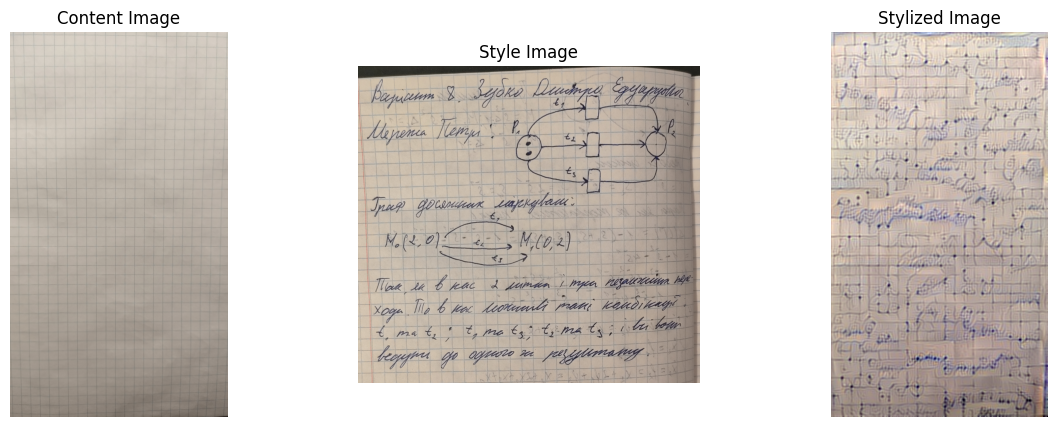

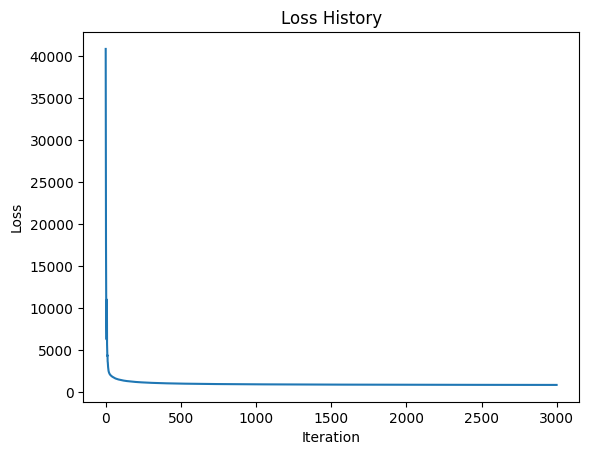

In [9]:
# Збереження результату
img = deprocess_image(combination_image.numpy())
fname = result_prefix + ".png"
keras.utils.save_img(fname, img)

# Відображення результатів
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(keras.utils.load_img(base_image_path))
plt.title("Content Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(keras.utils.load_img(style_reference_image_path))
plt.title("Style Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img)
plt.title("Stylized Image")
plt.axis('off')

plt.show()

plt.plot(losses_history)
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()